In [ ]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Feb  5 14:35:35 2025
Compare signal changes in roi between two RTs
fig 3 in the manuscript
@author: yuhui
"""
import os
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import glob
from statsmodels.stats.multitest import multipletests

In [ ]:
# Define data directory
data_dir = '/media/yuhui/LCT'

# Define stats prefix and coefficient list
stats_prefix = 'stats3.blur1.rbold.'
coef_list = ['ProbMM valueSH Fs', 'ProbMM valueSH Sl']

# Define ROI list
roi_list = [
    'lc', 'snvta', 'pos_pfc', 'NAc', 'caudate',
    'gray_bridge', 'putamen'
]

In [ ]:
roi_num = len(roi_list)
coef_num = len(coef_list)

######################################################
# Initialize results storage
df_results = []
all_roi_data = []
all_roi_sem = []
all_t_stats = []
all_p_vals = []

In [ ]:
for roi in roi_list:
    bold_mean_file = f"{stats_prefix}{roi}.1D"
    
    # Define the search pattern
    search_pattern = f"{data_dir}/2*/bold.sft/roiProfile/{bold_mean_file}"

    # Find all matching files
    bold_subj_list = sorted(glob.glob(search_pattern))
    
    subj_num = len(bold_subj_list)
    
    if subj_num > 0:
        roi_mean_all = np.zeros((coef_num, subj_num))
        
        for subj_idx, subj_file in enumerate(bold_subj_list):
            roi_mean_all[:, subj_idx] = np.loadtxt(subj_file)
        
        roi_mean = np.mean(roi_mean_all, axis=1)
        roi_sem = np.std(roi_mean_all, axis=1) / np.sqrt(subj_num)

        # Store ROI data for combined plot
        all_roi_data.append(roi_mean)
        all_roi_sem.append(roi_sem)
        
        # Perform paired t-tests for last two coefficients
        data1, data2 = roi_mean_all[-2, :], roi_mean_all[-1, :]
        t_stat, p_val = stats.ttest_rel(data1, data2)
        
        diff = data1 - data2
        cohen_d = np.mean(diff) / np.std(diff, ddof=1)
        df = subj_num-1
        
        df_results.append([roi, t_stat, p_val, cohen_d, df])
        all_t_stats.append(t_stat)
        all_p_vals.append(p_val)

# Convert results to DataFrame
df_results = pd.DataFrame(df_results, columns=['ROI', 't_value', 'p_value', 'Cohen_d', 'df'])

# Apply FDR correction (Benjamini-Hochberg)
p_vals_array = np.array(all_p_vals)  # Convert p-values to array
_, p_vals_corrected, _, _ = multipletests(p_vals_array, alpha=0.05, method='fdr_bh')

df_results["p_value_corrected"] = p_vals_corrected
print(df_results)

# Convert all ROI data to a NumPy array for plotting
all_roi_data = np.array(all_roi_data)
all_roi_sem = np.array(all_roi_sem)
all_t_stats = np.array(all_t_stats)
all_p_vals = np.array(all_p_vals)

           ROI   t_value   p_value   Cohen_d  df  p_value_corrected
0           lc  0.910391  0.374022  0.203570  19           0.436359
1        snvta -1.505827  0.148556 -0.336713  19           0.346631
2      pos_pfc  1.229709  0.233816  0.274971  19           0.382679
3          NAc  0.032344  0.974535  0.007232  19           0.974535
4      caudate  1.128050  0.273342  0.252240  19           0.382679
5  gray_bridge  3.167155  0.005074  0.708197  19           0.035518
6      putamen  2.342451  0.030198  0.523788  19           0.105695


++ save fig to the server


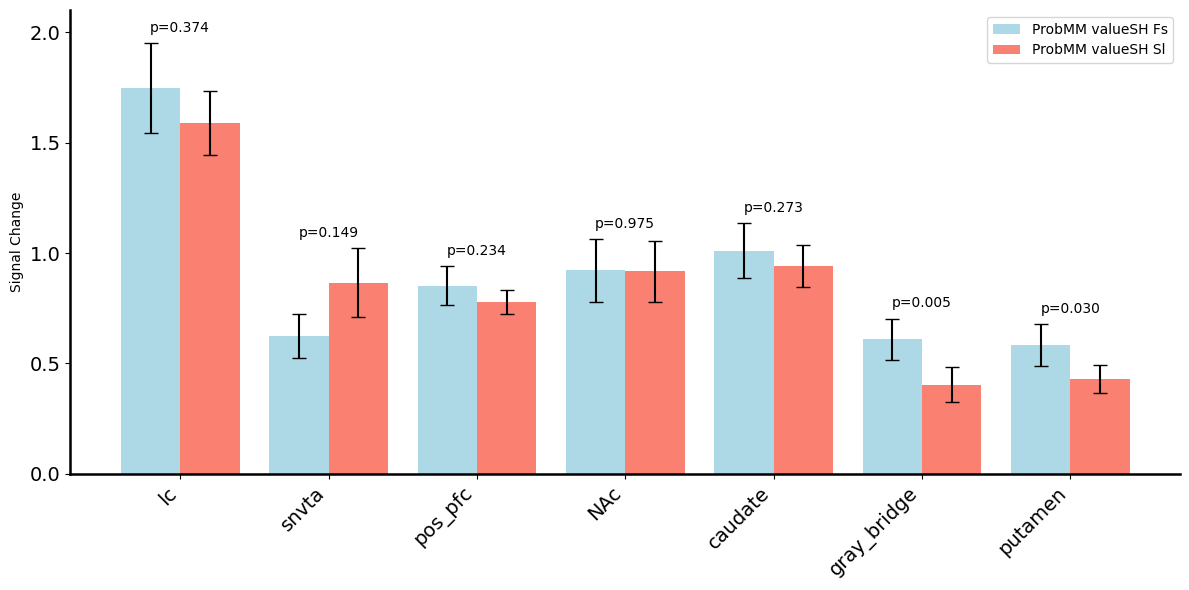

In [ ]:
######################################################
# Combined Bar Plot for All ROIs with Error Bars
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(roi_list))  # X-axis positions
width = 0.4  # Bar width

# Plot each coefficient as a paired bar with error bars
bars1 = ax.bar(x - width/2, all_roi_data[:, 0], width, label=coef_list[0],
               color='lightblue', yerr=all_roi_sem[:, 0], capsize=5)
bars2 = ax.bar(x + width/2, all_roi_data[:, 1], width, label=coef_list[1],
               color='salmon', yerr=all_roi_sem[:, 1], capsize=5)
# Set Y-axis limit to accommodate text annotations
max_y = np.max(all_roi_data + all_roi_sem)+0.15
ax.set_ylim(0, max_y)
# Annotate t-values and p-values above each pair of bars
# t={all_t_stats[i]:.2f}, 
for i in range(len(roi_list)):
    ax.text(x[i], max(all_roi_data[i]) + max(all_roi_sem[i]) + 0.05, 
            f"p={all_p_vals[i]:.3f}", 
            ha='center', fontsize=10, color='black')

ax.set_xticks(x)
ax.set_xticklabels(roi_list, rotation=45, ha='right')
ax.set_ylabel("Signal Change")
# ax.set_title("Mean Signal Change Across ROIs with Error Bars")
ax.tick_params(axis='y', labelsize=14)
ax.tick_params(axis='x', labelsize=14)
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_linewidth(1.8)  
ax.spines['bottom'].set_linewidth(1.8)
from matplotlib.ticker import MaxNLocator
ax.yaxis.set_major_locator(MaxNLocator(5))  # Limits to 5 ticks on y-axis
# # ax.grid(axis='y', linestyle='--', alpha=0.7)
# plt.show()
plt.tight_layout()
plt.savefig("output/roi_rt.png", dpi=300, bbox_inches='tight')
print("++ save fig to the server")